In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from data_reconstruct import *
from data_reconstruct.backend import *
from data_reconstruct.examples import *
from data_reconstruct.utilities import *

In [3]:
random_state = 42
np.random.seed(random_state)

# Load Data

In [4]:
# Read
mod1 = pd.read_csv('data/decennial_2020_nov8GAN.csv')[1:]
mod2 = pd.read_csv('data/public_150k_plus_210630.csv')
mod1_tagged = process_decennial(mod1)
mod2_tagged = process_ppp(mod2)
mod1, mod1_cols, mod1_tags_cols = mod1_tagged
mod2, mod2_cols, mod2_tags_cols = mod2_tagged

# Merge
mod1, mod2, annotations = merge_data(mod1_tagged, mod2_tagged, agg_by_tag=True)

# Sample
num_samples = min(mod1.shape[0], 2000)
mod1_sample = mod1.sample(num_samples, random_state=random_state)
mod2_sample = mod2.sample(num_samples, random_state=random_state)
annotations_sample = annotations.sample(num_samples, random_state=random_state);

# Generate Merged Anonymous Records

In [5]:
anonymized_data = anonymize(
    mod1_sample.to_numpy(),
    mod2_sample.to_numpy(),
    embedding_dim=5,
    embedding_kwargs={
        'project_mode': 'tsne',
        'epoch_pd': 2000,
        'log_pd': 200,
        'epoch_DNN': 200,
        'log_DNN': 100,
    },
)

use random seed: 666
Shape of Raw data
Dataset 0: (729, 6)
Dataset 1: (729, 4)
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
use device: cpu
epoch:[200/2000] err:0.4023 alpha:1.1304
epoch:[400/2000] err:0.1626 alpha:0.4578
epoch:[600/2000] err:0.1996 alpha:0.5643
epoch:[800/2000] err:0.2308 alpha:0.6561
epoch:[1000/2000] err:0.2571 alpha:0.7368
epoch:[1200/2000] err:0.2789 alpha:0.8077
epoch:[1400/2000] err:0.2965 alpha:0.8698
epoch:[1600/2000] err:0.3103 alpha:0.9243
epoch:[1800/2000] err:0.3205 alpha:0.9726
epoch:[2000/2000] err:0.3275 alpha:1.0156
Finished Matching!
---------------------------------
Begin finding the embedded space
epoch:[100/200]: loss:3.631184, align_loss:0.415126
epoch:[200/200]: loss:3.361049, align_loss:0.404889
Done
---------------------------------
unionCom Done!
time: 45.83662247657776 seconds


# Preview Results

In [6]:
pd.DataFrame(anonymized_data[0], index=annotations_sample.iloc[:, 0])

,0,1,2,3,4
ProjectCountyName,,,,,
NESHOBA,-1.383433,1.708681,-2.910186,-3.900701,-4.391394
CLEVELAND,3.724893,2.156146,-3.766773,0.833089,-2.208158
HUMBOLDT,2.144473,1.655481,-2.893021,0.253345,-1.918855
LAKE,2.238041,1.967923,-3.354432,-0.230235,-2.541021
PENOBSCOT,-0.596344,-0.752254,0.017594,-0.577819,-0.140831
...,...,...,...,...,...
BRAZOS,-0.963476,1.975549,-3.236617,-3.714817,-4.525455
CASCADE,1.451528,0.819079,-1.699406,0.669863,-0.729364
GUADALUPE,-0.970148,1.904166,-2.982475,-3.546943,-4.138350


# Usability

## Arbitrary Statistic Prediction

In [7]:
target = np.sqrt(mod1_sample['totalpop_other'] * mod2_sample['HEALTH_CARE_PROCEED']).to_numpy().reshape((-1, 1))
source = anonymized_data[0]

In [14]:
from data_reconstruct.backend import create_dataloader, train_model
from data_reconstruct.model_classes import Model

split_idx = int(.8 * target.shape[0])
training_loader = create_dataloader(source[:split_idx], target[:split_idx])
model = model_classes.Model(source.shape[1], 1, hidden_dim=20)
train_model(model, training_loader)
prediction = model(torch.Tensor(source)).detach().numpy()

Epoch:  10    Loss:  0.00781
Epoch:  20    Loss:  0.00713
Epoch:  30    Loss:  0.00662
Epoch:  40    Loss:  0.00630
Epoch:  50    Loss:  0.00609
Epoch:  60    Loss:  0.00601
Epoch:  70    Loss:  0.00598
Epoch:  80    Loss:  0.00595
Epoch:  90    Loss:  0.00592
Epoch: 100    Loss:  0.00589


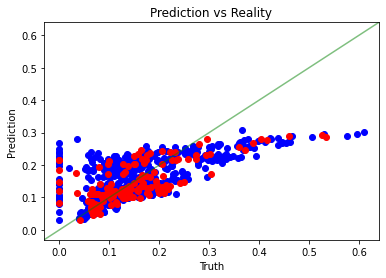

In [15]:
plot_example_results(target, prediction, split_idx=split_idx)